# Real-NVP in Jax (Demo)

Real-NVP implementation in less than 100 lines of [JAX](https://github.com/google/jax)

Author: Eric Jang

In [12]:
# !pip install --upgrade jax jaxlib scikit-learn

In [11]:
import jax.numpy as np
from jax import random

## Data

$p(x)$

In [2]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

(-2, 2)

In [6]:
# Initialize parameters, not committing to a batch shape
rng = random.PRNGKey(0)

/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [10]:
# N(1, 1)
X = random.normal(rng, (n_samples, 2)) + 1

## Base Distribution

In [284]:
def sample_n01(N):
  return random.normal(rng, (N, self.D))

def log_prob_n01(x):
  return np.sum(-np.square(x)/2 - np.log(np.sqrt(2*np.pi)),axis=-1)

(array([ 24., 173., 477., 393., 144.,  97.,  90., 116., 136., 350.]),
 array([-3.747913 , -3.56515  , -3.382387 , -3.199624 , -3.0168612,
        -2.8340983, -2.6513352, -2.4685724, -2.2858095, -2.1030464,
        -1.9202836], dtype=float32),
 <a list of 10 Patch objects>)

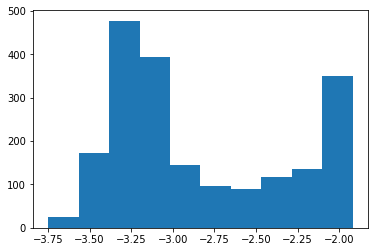

In [283]:
plt.hist(log_prob_n01(X))

## Real-NVP

Affine coupling layer

$x_2=x_1$

$y_2=x_1*e^{s(x_1)}+t(x_1)$

In [6]:
from jax.experimental import stax # neural network library
from jax.experimental.stax import Dense, Relu # neural network layers

In [109]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
  # TODO

In [110]:
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
  # TODO


$\log p(x) = \log p(f^{-1}(x)) + |\log det J(f^{-1})(x)| $

In [199]:
def init_nvp():
  D = 2
  net_init, net_apply = stax.serial(
    Dense(512), Relu, Dense(512), Relu, Dense(D))
  in_shape = (-1, D//2)
  out_shape, net_params = net_init(rng, in_shape)
  def shift_and_log_scale_fn(net_params, x1):
    s = net_apply(net_params, x1)
    return np.split(s, 2, axis=1)
  return net_params, shift_and_log_scale_fn

def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
  x = base_sample_fn(N)
  return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
  # TODO

In [201]:
def init_nvp_chain(n=2):
  flip = False
  ps, configs = [], []
  for i in range(n):
    p, f = init_nvp()
    ps.append(p), configs.append((f, flip))
    flip = not flip
  return ps, configs

def sample_nvp_chain(ps, configs, base_sample_fn, N):
  x = base_sample_fn(N)
  for p, config in zip(ps, configs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  return x

def make_log_prob_fn(p, log_prob_fn, config):
  shift_log_scale_fn, flip = config
  return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
  log_prob_fn = base_log_prob_fn
  for p, config in zip(ps, configs):
    log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
  return log_prob_fn(y)

In [202]:
ps, cs = init_nvp_chain(4)
y = sample_nvp_chain(ps, cs, dist, 1000)

(array([ 11.,  22.,  37.,  97., 193., 241., 122.,  58.,  96., 123.]),
 array([-4.3715196, -4.1426826, -3.9138453, -3.685008 , -3.456171 ,
        -3.2273338, -2.9984965, -2.7696595, -2.5408223, -2.3119853,
        -2.083148 ], dtype=float32),
 <a list of 10 Patch objects>)

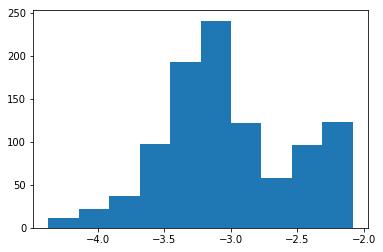

In [203]:
plt.hist(log_prob_nvp_chain(ps, cs, dist, X))

## Train It

In [212]:
from jax.experimental import optimizers
from jax import jit, grad
ps, cs = init_nvp_chain(4)

def loss(params, batch):
  return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
  params = get_params(opt_state)
  g = grad(loss)(params, batch)
  return opt_update(i, g, opt_state)

iters = int(1e4)
data_generator = (X[random.choice(rng, X.shape[0], 100)] for _ in range(iters))
opt_state = opt_init(ps)
for i in range(iters):
  opt_state = step(i, opt_state, next(data_generator))
ps = get_params(opt_state)

In [213]:
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

In [214]:
y.max()

DeviceArray(1.893881, dtype=float32)

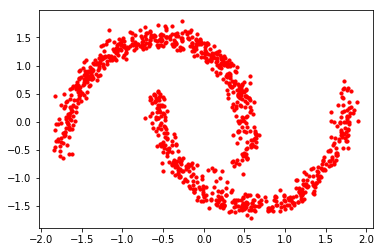

In [215]:
plt.scatter(y[:, 0], y[:, 1], s=10, color='red')
xlim, ylim = [-3, 3], [-3, 3]
# plt.xlim(xlim)
# plt.ylim(ylim)

## Animation

In [225]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [ ]:
# !brew install imagemagick

In [275]:
x = dist.sample(1000)
values = [x]
for p, config in zip(ps, cs):
  shift_log_scale_fn, flip = config
  x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  values.append(x)

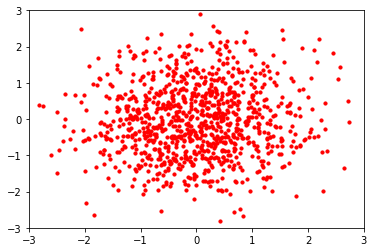

In [276]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

y = values[0]
paths = ax.scatter(y[:, 0], y[:, 1], s=10, color='red')

In [277]:
# Reverse the list to view animation in reverse.
# values = list(reversed(values))

In [278]:
def animate(i):
  l = i//48
  t = (float(i%48))/48
  y = (1-t)*values[l] + t*values[l+1]
  paths.set_offsets(y)
  return (paths,)

In [279]:
anim = animation.FuncAnimation(fig, animate, frames=48*len(cs), interval=1, blit=False)

In [280]:
anim.save('anim2.gif', writer='imagemagick', fps=60)

In [281]:
Image(url='anim2.gif')